In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
import seaborn as sns
import itertools
import pandas as pd
from functools import lru_cache
from tqdm import tqdm 


In [2]:
parameter_grid = {
    'mu_X': [0],                 # Mean of X
    'sigma_X': [0.5],      # Standard deviation of X
    'mu_epsilon': [0],           # Mean of epsilon
    'sigma_epsilon': [0.5] # Standard deviation of epsilon
}


In [3]:

sns.set(style="darkgrid")  
plt.style.use('dark_background')

plt.rcParams.update({
    'axes.facecolor': '#2E2E2E',
    'figure.facecolor': '#2E2E2E',
    'axes.edgecolor': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'text.color': 'white',
    'grid.color': 'gray',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
})

In [4]:


def generate_data(mu_X, sigma_X, mu_epsilon, sigma_epsilon, n_samples, seed=None):
    if seed is not None:
        np.random.seed(seed)
    X = np.random.normal(mu_X, sigma_X, n_samples)
    epsilon = np.random.normal(mu_epsilon, sigma_epsilon, n_samples)
    Y = X + epsilon
    return X, Y

def compute_conditional_expectation(y, mu_X, sigma_X, mu_epsilon, sigma_epsilon):
    def integrand(x):
        return x * norm.pdf(x, mu_X, sigma_X) * norm.pdf(y, x + mu_epsilon, sigma_epsilon)
    
    def normalization(x):
        return norm.pdf(x, mu_X, sigma_X) * norm.pdf(y, x + mu_epsilon, sigma_epsilon)
    
    numerator, _ = quad(integrand, -np.inf, np.inf, limit=100)
    denominator, _ = quad(normalization, -np.inf, np.inf, limit=100)
    
    return numerator / denominator

@lru_cache(maxsize=None)
def cached_conditional_expectation(y, mu_X, sigma_X, mu_epsilon, sigma_epsilon):
    return compute_conditional_expectation(y, mu_X, sigma_X, mu_epsilon, sigma_epsilon)

def estimate_X_integral(Y, mu_X, sigma_X, mu_epsilon, sigma_epsilon):
    X_hat = np.array([cached_conditional_expectation(y, mu_X, sigma_X, mu_epsilon, sigma_epsilon) for y in tqdm(Y, desc="Estimating X via Integration")])
    return X_hat

def evaluate_performance(X, X_hat, sigma_X, sigma_epsilon):
    mse = np.mean((X - X_hat) ** 2)
    theoretical_mse = (sigma_X**2 * sigma_epsilon**2) / (sigma_X**2 + sigma_epsilon**2)
    return mse, theoretical_mse


In [5]:

def visualize_results(X, X_hat, errors, mu_X, sigma_X, sigma_epsilon, mse, theoretical_mse):
    plt.figure(figsize=(10, 8))
    plt.scatter(
        X, X_hat,
        alpha=0.3,
        s=10,
        label='MMSE Estimates',
        color='cyan',
        edgecolor='none'
    )
    plt.plot(
        [X.min(), X.max()],
        [X.min(), X.max()],
        color='magenta',
        linestyle='--',
        linewidth=2,
        label='Ideal (X = X_hat)'
    )
    plt.xlabel('True X', fontsize=14)
    plt.ylabel('Estimated X (MMSE)', fontsize=14)
    plt.title(f'MMSE Estimator: True vs Estimated X\n(mu_X={mu_X}, sigma_X={sigma_X}, sigma_epsilon={sigma_epsilon})', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 8))
    bins = 50
    plt.hist(
        X,
        bins=bins,
        alpha=0.5,
        label='True X',
        density=True,
        color='skyblue',
        edgecolor='black'
    )
    plt.hist(
        X_hat,
        bins=bins,
        alpha=0.5,
        label='Estimated X (MMSE)',
        density=True,
        color='salmon',
        edgecolor='black'
    )
    plt.xlabel('Value', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.title(f'Histogram of True X and Estimated X (MMSE)\n(MSE={mse:.4f}, Theoretical MSE={theoretical_mse:.4f})', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 8))
    plt.hist(
        errors,
        bins=50,
        alpha=0.7,
        color='lime',
        density=True,
        label='Estimation Errors',
        edgecolor='black'
    )
    mu_error = 0
    sigma_error = np.sqrt(theoretical_mse)
    x_vals = np.linspace(errors.min(), errors.max(), 1000)
    plt.plot(
        x_vals,
        norm.pdf(x_vals, mu_error, sigma_error),
        color='yellow',
        linestyle='-',
        linewidth=2,
        label='Theoretical Error PDF'
    )
    plt.xlabel('Error (X - X_hat)', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.title(f'Distribution of Estimation Errors\n(Normal(0, {theoretical_mse:.4f}))', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [6]:
def additional_analysis(X, X_hat):
    corr_coef = np.corrcoef(X, X_hat)[0, 1]
    r_squared = corr_coef**2
    print(f"\n--- Additional Analysis ---")
    print(f"Correlation Coefficient between X and X_hat: {corr_coef:.4f}")
    print(f"R^2 (Coefficient of Determination): {r_squared:.4f}")

def run_simulation_integral(parameter_grid, n_samples=10000, seed=42):
    results = []
    
    keys, values = zip(*parameter_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    for params in param_combinations:
        print(f"\nRunning simulation with parameters: {params}")
        X, Y = generate_data(
            mu_X=params['mu_X'],
            sigma_X=params['sigma_X'],
            mu_epsilon=params['mu_epsilon'],
            sigma_epsilon=params['sigma_epsilon'],
            n_samples=n_samples,
            seed=seed
        )
        X_hat = estimate_X_integral(Y, params['mu_X'], params['sigma_X'], params['mu_epsilon'], params['sigma_epsilon'])
        mse, theoretical_mse = evaluate_performance(X, X_hat, params['sigma_X'], params['sigma_epsilon'])
        errors = X - X_hat
        visualize_results(X, X_hat, errors, params['mu_X'], params['sigma_X'], params['sigma_epsilon'], mse, theoretical_mse)
        additional_analysis(X, X_hat)
        
        corr_coef = np.corrcoef(X, X_hat)[0,1]
        result = {
            'mu_X': params['mu_X'],
            'sigma_X': params['sigma_X'],
            'mu_epsilon': params['mu_epsilon'],
            'sigma_epsilon': params['sigma_epsilon'],
            'Estimated MSE': mse,
            'Theoretical MSE': theoretical_mse,
            'Correlation Coefficient': corr_coef,
            'R_squared': corr_coef**2
        }
        results.append(result)
    
    results_df = pd.DataFrame(results)
    return results_df



Running simulation with parameters: {'mu_X': 0, 'sigma_X': 0.5, 'mu_epsilon': 0, 'sigma_epsilon': 0.5}


Estimating X via Integration: 100%|██████████| 10000/10000 [20:57<00:00,  7.95it/s]


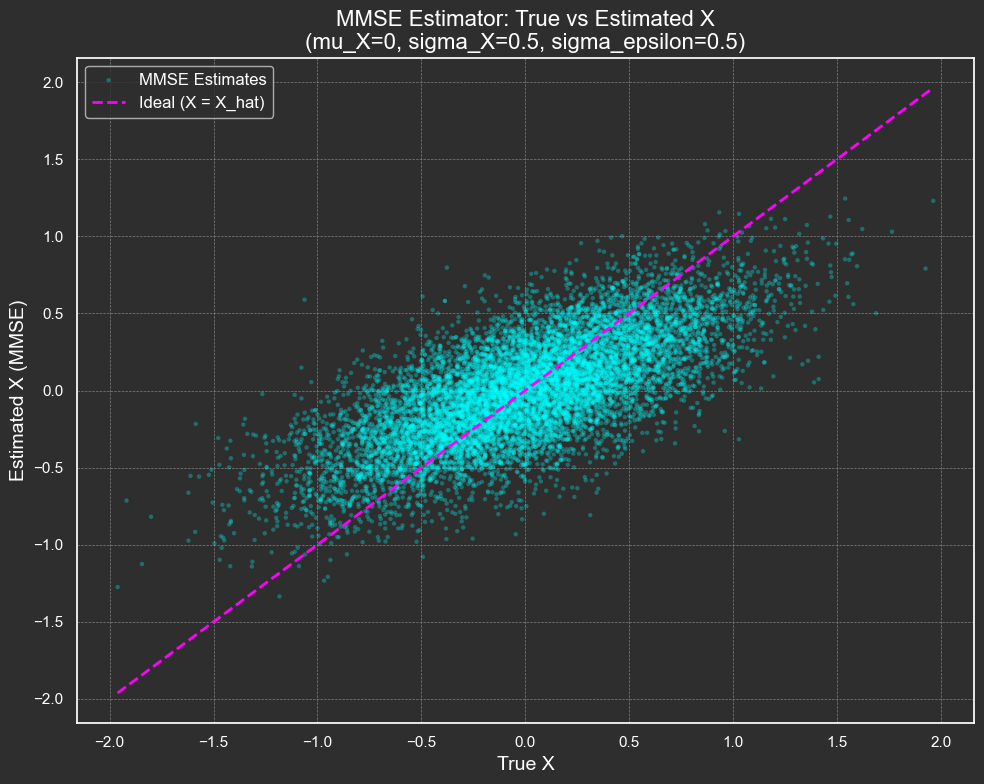

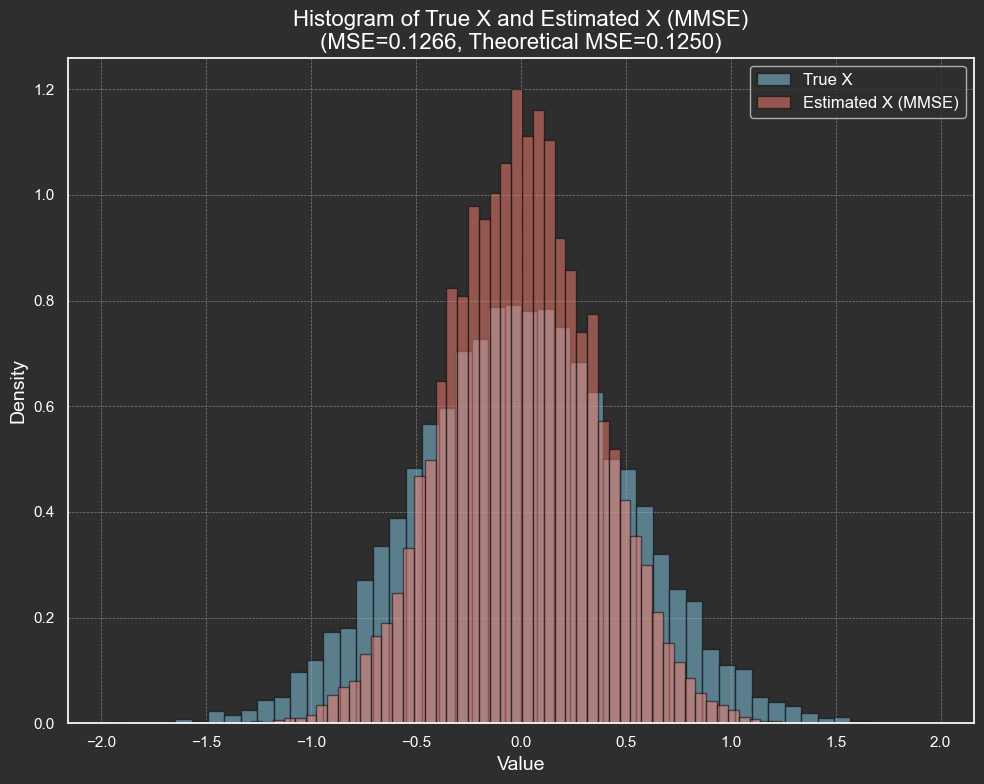

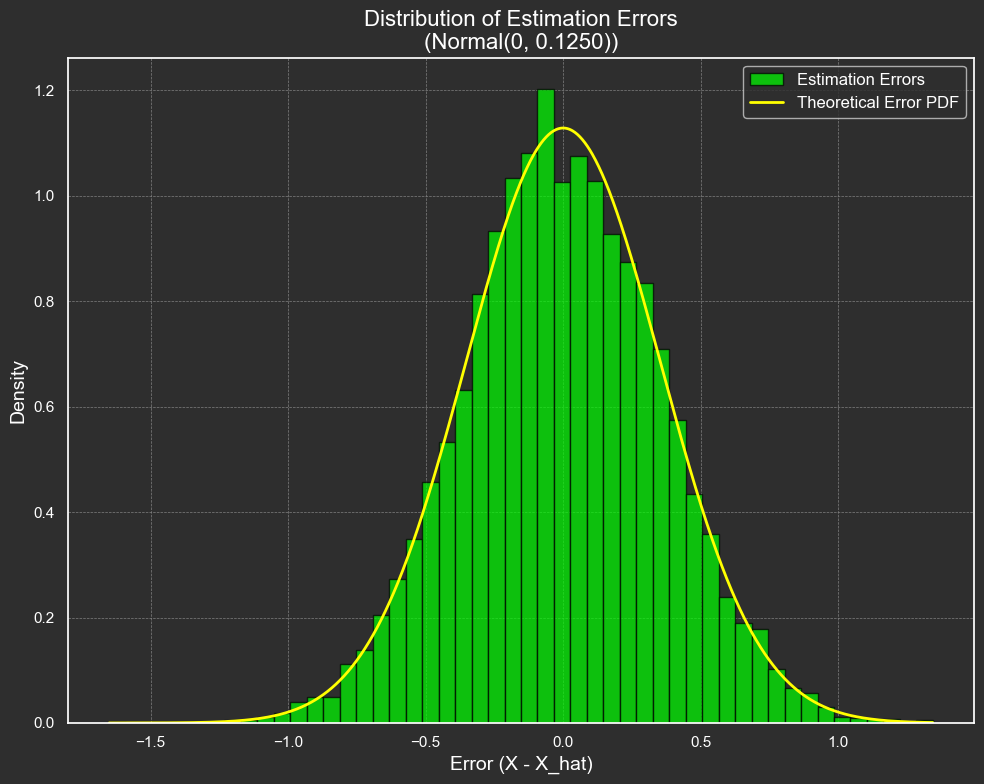


--- Additional Analysis ---
Correlation Coefficient between X and X_hat: 0.7050
R^2 (Coefficient of Determination): 0.4970

=== Summary of Simulation Results ===
   mu_X  sigma_X  mu_epsilon  sigma_epsilon  Estimated MSE  Theoretical MSE  \
0     0      0.5           0            0.5       0.126637            0.125   

   Correlation Coefficient  R_squared  
0                 0.704952   0.496957  


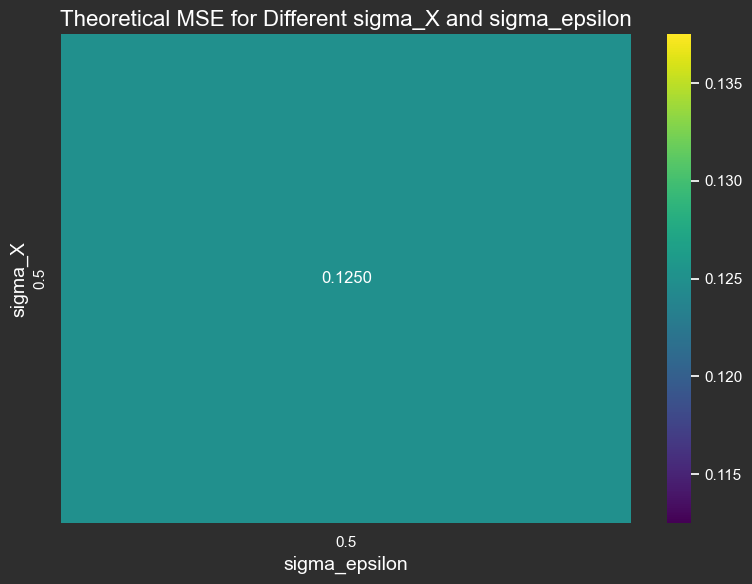

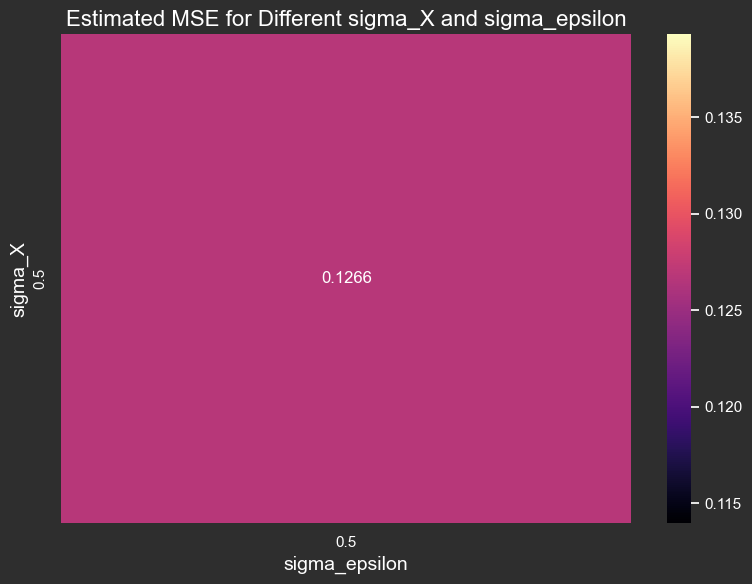

In [7]:

results_df = run_simulation_integral(parameter_grid, n_samples=10000, seed=42)

print("\n=== Summary of Simulation Results ===")
print(results_df)

pivot_table_theoretical = results_df.pivot(index="sigma_X", columns="sigma_epsilon", values="Theoretical MSE")
pivot_table_estimated = results_df.pivot(index="sigma_X", columns="sigma_epsilon", values="Estimated MSE")

plt.figure(figsize=(8,6))
sns.heatmap(pivot_table_theoretical, annot=True, fmt=".4f", cmap="viridis")
plt.title("Theoretical MSE for Different sigma_X and sigma_epsilon", fontsize=16)
plt.xlabel("sigma_epsilon", fontsize=14)
plt.ylabel("sigma_X", fontsize=14)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(pivot_table_estimated, annot=True, fmt=".4f", cmap="magma")
plt.title("Estimated MSE for Different sigma_X and sigma_epsilon", fontsize=16)
plt.xlabel("sigma_epsilon", fontsize=14)
plt.ylabel("sigma_X", fontsize=14)
plt.tight_layout()
plt.show()